<center>
<img src="../../img/ods_stickers.jpg">
# <center> Open Machine Learning Course
<center> Author: Egor Polusmak, Head of Data Analytics at Mail.Ru Search.

The material is distributed under [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). You are free to use the material for any non-commercial purposes, but you must give credit to the original author.

# <center>Topic 9. Time series analysis in Python</center>
## <center>Part 2. Predicting the future with Facebook Prophet</center>

Time series forecasting finds wide application in data analytics. These are only some of the conceivable predictions of future trends that might be useful:
- The number of servers that an online service will need next year.
- The demand for a grocery product at a supermarket on a given day.
- The tomorrow closing price of a tradable financial asset.

For another example, we can make a prediction of some team's performance and then use it as a baseline: first to set goals for the team, and then to measure the actual team performance relative to the baseline.

There are quite a few different methods to predict future trends, for example, [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), [ARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity), [regressive models](https://en.wikipedia.org/wiki/Autoregressive_model), [neural networks](https://medium.com/machine-learning-world/neural-networks-for-algorithmic-trading-1-2-correct-time-series-forecasting-backtesting-9776bfd9e589).

In this article, we will look at [Prophet](https://facebook.github.io/prophet/), a library for time series forecasting released by Facebook and open-sourced on February 23, 2017. We will also try it out in the problem of predicting the daily number of posts published on Medium.

## Article outline

1. Introduction
2. The Prophet Forecasting Model
3. Practice with Prophet
    * 3.1 Installation in Python
    * 3.2 Dataset
    * 3.3 Exploratory visual analysis
    * 3.4 Making a forecast
    * 3.5 Forecast quality evaluation
    * 3.6 Visualization
4. Box-Cox Transformation
5. Summary
6. References

## 1. Introduction

According to the [article](https://research.fb.com/prophet-forecasting-at-scale/) on Facebook Research, Prophet was initially developed for the purpose of creating high quality business forecasts. This library tries to address the following difficulties common to many business time series:
- Seasonal effects caused by human behavior: weekly, monthly and yearly cycles, dips and peaks on public holidays.
- Changes in trend due to new products and market events.
- Outliers.

The authors claim that, even with the default settings, in many cases, their library produces forecasts as accurate as those delivered by experienced analysts.

Moreover, Prophet has a number of intuitive and easily interpretable customizations that allow gradually improving the quality of the forecasting model. What is especially important, these paramaters are quite comprehensible even for non-experts in time series analysis, which is a field of data science requiring certain skill and experience.

By the way, the original article is called "Forecasting at Scale", but it is not about the scale in the "usual" sense, that is addressing computational and infrastructure problems of a large number of working programs. According to the authors, Prophet should scale well in the following 3 areas:
- Accessibility to a wide audience of analysts, possibly without profound expertise in time series.
- Applicability to a wide range of distinct forecasting problems.
- Automated performance estimation of a large number of forecasts including flagging of potential problems for their subsequent inspection by the analyst.

## 2. The Prophet Forecasting Model

Now, let's take a closer look at how Prophet works. In its essence, this library utilizes the [additive regression model](https://en.wikipedia.org/wiki/Additive_model) $y(t)$ comprising the following components:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t},$$

where:
* Trend $g(t)$ models non-periodic changes.
* Seasonality $s(t)$ represents periodic changes.
* Holidays component $h(t)$ contributes information about holidays and events.

Below, we will consider some important properties of these model components.

### Trend

The Prophet library implements two possible trend models for $g(t)$.

The first one is called *Nonlinear, Saturating Growth*. It is represented in the form of the [logistic growth model](https://en.wikipedia.org/wiki/Logistic_function):

$$g(t) = \frac{C}{1+e^{-k(t - m)}},$$

where:
* $C$ is the carrying capacity (that is the curve's maximum value).
* $k$ is the growth rate (which represents "the steepness" of the curve).
* $m$ is an offset parameter.

This logistic equation allows modelling non-linear growth with saturation, that is when the growth rate of a value decreases with its growth. One of the typical examples would be representing the growth of the audience of an application or a website.

Actually, $C$ and $k$ are not necessarily constants and may vary over time. Prophet supports both automatic and manual tuning of their variability. The library can itself choose optimal points of trend changes by fitting the supplied historical data. 

Also, Prophet allows analysts to manually set changepoints of the growth rate and capacity values at different points in time. For instance, analysts may have insights about dates of past releases that prominently influenced some key product indicators.

The second trend model is a simple *Piecewise Linear Model* with a constant rate of growth. It is best suited for problems without saturating growth.

### Seasonality

The seasonal component $s(t)$ provides a flexible model of periodic changes due to weekly and yearly seasonality.

Weekly seasonal data is modeled with dummy variables. Six new variables are added: `monday`, `tuesday`, `wednesday`, `thursday`, `friday`, `saturday`, which take values 0 or 1 depending on the day of the week. The feature `sunday` is not added because it would be a linear combination of the other days of the week, and this fact would have an adverse effect on the model.

Yearly seasonality model in Prophet relies on Fourier series.

Since [version 0.2](https://github.com/facebook/prophet) you can also use *sub-daily time series* and make *sub-daily forecasts* as well as employ the new *daily seasonality* feature.

### Holidays and Events

The component $h(t)$ represents predictable abnormal days of the year including those on irregular schedules, e.g., Black Fridays.

To utilize this feature, the analyst needs to provide a custom list of events.

### Error

The error term $\epsilon(t)$ represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.

### Prophet Benchmarking

For a detailed description of the model and algorithms behind Prophet refer to the paper ["Forecasting at scale"](https://peerj.com/preprints/3190/) by Sean J. Taylor and Benjamin Letham.

The authors also compared their library with several other methods for time series forecasting. They used [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) as a measure of prediction accuracy. In this research, Prophet has shown substantially lower forecasting error than the other models.

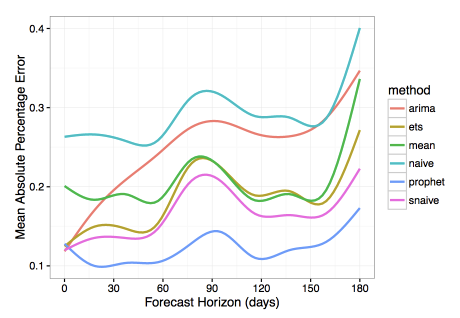

Let's look closer at how the forcasting quality was measured in the article. To do this, we will need the formula of Mean Absolute Percentage Error.

Let $y_{i}$ be the *actual (historical) value* and $\hat{y}_{i}$ be the *forecast value* given by our model.

Then $e_{i} = y_{i} - \hat{y}_{i}$ is the *forecast error* and $p_{i} =\frac{\displaystyle e_{i}}{\displaystyle y_{i}}$ is the *relative forecast error*.

We define

$$MAPE = mean\big(\left |p_{i} \right |\big)$$

MAPE is widely used as a measure of prediction accuracy because it expresses error as a percentage and thus can be used in model evaluations on different datasets.

In addition, when evaluating a forecasting algorithm, it may prove useful to calculate [MAE (Mean Absolute Error)](https://en.wikipedia.org/wiki/Mean_absolute_error) in order to have a picture of errors in absolute numbers. Using previously defined components, its equation will be

$$MAE = mean\big(\left |e_{i}\right |\big)$$

A few words about the algorithms that Prophet was compared with. Most of them are quite simple and often are used as a baseline for other models:
* `naive` is a simplistic forecasting approach where we predict all future values relying solely on the observation at the last available point of time.
* `snaive` (seasonal naive) is a model that makes constant predictions taking into account information about seasonality. For instance, in the case of weekly seasonal data for each future Monday, we would predict the value from the last Monday, and for all future Tuesdays we would use the value from the last Tuesday and so on.
* `mean` uses the averaged value of data as a forecast.
* `arima` stands for *Autoregressive Integrated Moving Average*, see [Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) for details.
* `ets` stands for *Exponential Smoothing*, see [Wikipedia](https://en.wikipedia.org/wiki/Exponential_smoothing) for more.

## 3. Practice with Facebook Prophet

### 3.1 Installation in Python

First, you need to install the library. Prophet is available for Python and R. The choice will depend on your personal preferences and project requirements. Further in this article we will use Python.

In Python you can install Prophet using PyPI:
```
$ pip install fbprophet
```

In R you can find the corresponing CRAN package. Refer to the [documentation](https://facebookincubator.github.io/prophet/docs/installation.html) for details.

Let's import the modules that we will need, and initialize our environment:

In [3]:
# !pip install fbprophet

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

### 3.2 Dataset

We will predict the daily number of posts published on [Medium](https://medium.com/).

First, we load our dataset.

In [5]:
df = pd.read_csv('./data/medium_posts.csv.zip', sep='\t')

Next, we leave out all columns except `published` and `url`. The former corresonds to the time dimension while the latter uniquely identifies a post by its URL. Along the way we get rid of possible duplicates and missing values in the data:

In [6]:
df = df[['published', 'url']].dropna().drop_duplicates()

Next, we need to convert `published` to the datetime format because by default `pandas` treats this field as string-valued.

In [7]:
df['published'] = pd.to_datetime(df['published'])

Let's sort the dataframe by time and take a look at what we've got:

In [8]:
df.sort_values(by=['published']).head(n=3)

,published,url
50931,1970-01-01 00:00:00.001,https://medium.com/iiot
40243,1970-01-01 00:00:00.001,https://medium.com/@ikaella/melon-rebranding-b...
37395,1970-01-18 05:11:46.500,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...


Medium's public release date was August 15, 2012. But, as you can see from the data above, there are at least several rows with much earlier publication dates. They have somehow turned up in our dataset, but they are hardly legitimate ones. We will just trim our time series to keep only those rows that fall onto the period from August 15, 2012 to June 25, 2017:

In [9]:
df = df[(df['published'] > '2012-08-15') & (df['published'] < '2017-06-26')].sort_values(by=['published'])
df.head(n=3)

,published,url
24630,2012-08-15 00:25:03.373,https://medium.com/launch-day/jean-attempts-to...
24631,2012-08-15 00:25:29.419,https://medium.com/launch-day/dan-and-kristin-...
17811,2012-08-15 00:34:59.502,https://medium.com/i-m-h-o/the-world-is-social...


In [10]:
df.tail(n=3)

,published,url
62122,2017-06-25 23:36:01.171,https://medium.com/push-the-pace/the-official-...
72471,2017-06-25 23:41:48.295,https://medium.com/parti-xyz-developers/%EA%B4...
83283,2017-06-25 23:51:43.000,http://www.johanr.com/blog/people-support-dreams


As we are going to predict the number of published posts, we will aggregate and count unique posts at each given point in time. We will name the corresponding new column `posts`:

In [11]:
aggr_df = df.groupby('published')[['url']].count()
aggr_df.columns = ['posts']

In this practice, we are interested in the number of posts **a day**. But at this moment all our data is divided into irregular time intervals that are less than a day. This is called a *sub-daily time series*. To see it, let's print out the first 3 rows:

In [12]:
aggr_df.head(n=3)

,posts
published,
2012-08-15 00:25:03.373,1
2012-08-15 00:25:29.419,1
2012-08-15 00:34:59.502,1


To fix this, we need to aggregate the post counts by "bins" of a date size. In time series analysis, this process is referred to as *resampling*. And if we *reduce* the sampling rate of data it is often called *downsampling*.

Luckily, `pandas` has a built-in functionality for this task. We will resample our time index down to 1-day bins:

In [13]:
daily_df = aggr_df.resample('D').apply(sum)
daily_df.head(n=3)

,posts
published,
2012-08-15,16
2012-08-16,11
2012-08-17,4


### 3.3 Exploratory visual analysis

As always, it may be helpful and instructive to look at a graphical representation of your data.

We will create a time series plot for the whole time range. Displaying data over such a long period of time can give clues about seasonality and conspicuous abnormal deviations.

First, we import and initialize the `Plotly` library, which allows creating beautiful interactive plots:

In [14]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

We also define a helper function, which will plot our dataframes throughout the article:

In [15]:
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

Let's try and plot our dataset *as is*:

In [16]:
plotly_df(daily_df, title='Posts on Medium (daily)')

High-frequency data can be rather difficult to analyze. Even with the ability to zoom in provided by `Plotly`, it is hard to infer anything meaningful from this chart apart from the prominent upward and accelerating trend.

To reduce the noise, we will resample the post counts down to weekly bins. Besides *binning*, other possible techniques of noise reduction include [Moving-Average Smoothing](https://en.wikipedia.org/wiki/Moving_average) and [Exponential Smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing), among others.

We save our downsampled dataframe in a separate variable because further in this practice we will work only with daily series:

In [17]:
weekly_df = daily_df.resample('W').apply(sum)

Finally, we plot the result:

In [18]:
plotly_df(weekly_df, title='Posts on Medium (weekly)')

This downsampled chart proves to be somewhat better for an analyst's perception.

One of the most useful functions that `Plotly` provides is the ability to quickly dive into different periods of timeline in order to better understand the data and find visual clues about possbile trends, periodic and irregular effects. 

For example, zooming-in on a couple of consecutive years shows us time points corresponding to Christmas holidays, which greatly influence human behaviors.

Now, we're going to omit the first few years of observations, up to 2015. First, they won't contribute much into the forecast quality in 2017. Second, these first years, having very low number of posts per day, are likely to increase noise in our predictions, as the model would be forced to fit this abnormal historical data along with more relevant and indicative data from the recent years.

In [19]:
daily_df = daily_df.loc[daily_df.index >= '2015-01-01']
daily_df.head(n=3)

,posts
published,
2015-01-01,8
2015-01-02,11
2015-01-03,11


To sum up, from visual analysis we can see that our dataset is non-stationary with a prominent growing trend. It also demonstrates weekly and yearly seasonality and a number of abnormal days in each year.

### 3.4 Making a forecast

Prophet's API is very similar to the one you can find in `sklearn`. First we create a model, then call the method `fit`, and, finally, make a forecast. The input to the method `fit` is a `DataFrame` with two columns:
* `ds` (datestamp) must be of type `date` or `datetime`.
* `y` is a numeric value we want to predict.

To get started, we'll import the library and mute unimportant diagnostic messages:

In [21]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

Let's convert our dataframe to the format required by Prophet:

In [22]:
df = daily_df.reset_index()
df.columns = ['ds', 'y']
df.tail(n=3)

,ds,y
904,2017-06-23,421
905,2017-06-24,277
906,2017-06-25,253


The authors of the library generally advise to make predictions based on at least several months, ideally, more than a year of historical data. Luckily, in our case we have more than a couple of years of data to fit the model.

To measure the quality of our forecast, we need to split our dataset into the *historical part*, which is the first and biggest slice of our data, and the *prediction part*, which will be located at the end of the timeline. We will remove the last month from the dataset in order to use it later as a prediction target:

In [23]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
874,2017-05-24,375
875,2017-05-25,298
876,2017-05-26,269


Now we need to create a new `Prophet` object. Here we can pass the parameters of the model into the constructor. But in this article we will use the defaults. Then we train our model by invoking its `fit` method on our training dataset:

In [24]:
m = Prophet()
m.fit(train_df);

Using the helper method `Prophet.make_future_dataframe`, we create a dataframe which will contain all dates from the history and also extend into the future for those 30 days that we left out before.

In [25]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
904,2017-06-23
905,2017-06-24
906,2017-06-25


We predict values with `Prophet` by passing in the dates for which we want to create a forecast. If we also supply the historical dates (as in our case), then in addition to the prediction we will get an in-sample fit for the history. Let's call the model's `predict` method with our `future` dataframe as an input:

In [26]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
904,2017-06-23,277.992028,253.547669,304.147234,277.484743,278.323524,2.242612,2.242612,2.242612,3.473493,3.473493,3.473493,-1.230880,-1.230880,-1.230880,0.0,0.0,0.0,280.234641
905,2017-06-24,278.710324,219.166214,269.070387,278.183744,279.070650,-35.065401,-35.065401,-35.065401,-34.023843,-34.023843,-34.023843,-1.041558,-1.041558,-1.041558,0.0,0.0,0.0,243.644924
906,2017-06-25,279.428621,223.764616,273.881371,278.867106,279.816552,-31.432830,-31.432830,-31.432830,-30.580216,-30.580216,-30.580216,-0.852614,-0.852614,-0.852614,0.0,0.0,0.0,247.995791


In the resulting dataframe you can see many columns characterizing the prediction, including trend and seasonality components as well as their confidence intervals. The forecast itself is stored in the `yhat` column.

The Prophet library has its own built-in tools for visualization that enable us to quickly evaluate the result.

First, there is a method called `Prophet.plot` that plots all the points from the forecast:

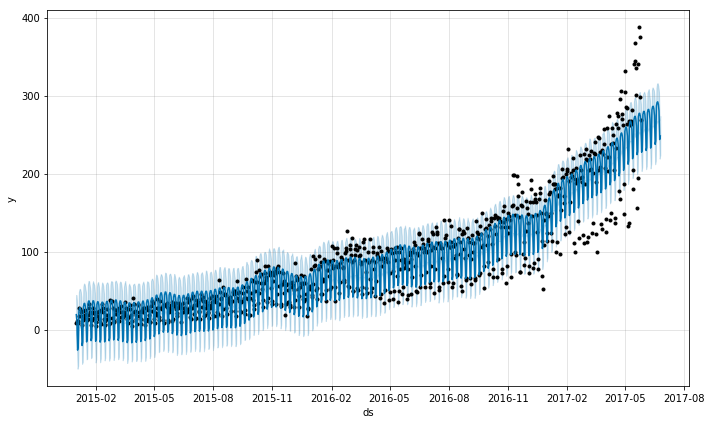

In [27]:
m.plot(forecast);

This chart doesn't look very informative. The only definitive conclusion that we can draw here is that the model treated many of the data points as outliers.

The second function `Prophet.plot_components` might be much more useful in our case. It allows us to observe different components of the model separately: trend, yearly and weekly seasonality. In addition, if you supply information about holidays and events to your model, they will also be shown in this plot.

Let's try it out:

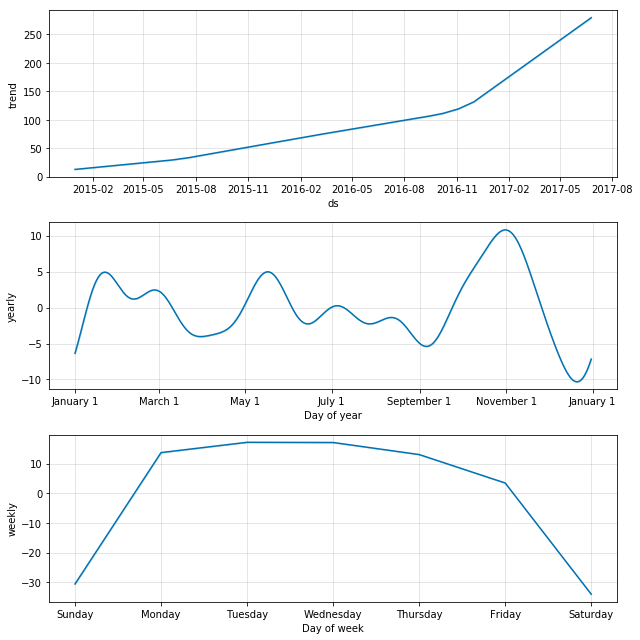

In [28]:
m.plot_components(forecast);

As you can see from the trend graph, Prophet did a good job by fitting the accelerated growth of new posts at the end of 2016. The graph of weekly seasonality leads to the conclusion that usually there are less new posts on Saturdays and Sundays than on the other days of the week. In the yearly seasonality graph there is a prominent dip on Christmas Day.

### 3.5 Forecast quality evaluation

Let's evaluate the quality of the algorithm by calculating the error metrics for the last 30 days that we predicted. For this, we will need the observations $y_i$ and the corresponding predicted values $\hat{y}_i$.

Let's look into the object `forecast` that the library created for us:

In [29]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


We can see that this dataframe contains all the information we need except for the historical values. We need to join the `forecast` object with the actual values `y` from the original dataset `df`. For this we will define a helper function that we will reuse later:

In [30]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

Let's apply this function to our last forecast:

In [31]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-06-23,280.234641,253.547669,304.147234,421
2017-06-24,243.644924,219.166214,269.070387,277
2017-06-25,247.995791,223.764616,273.881371,253


We are also going to define a helper function that we will use to gauge the quality of our forecasting with MAPE and MAE error measures:

In [32]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

Let's use our function:

In [33]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 22.566119266921035
MAE 69.62700966533414


As a result, the relative error of our forecast (MAPE) is about 22.72%, and on average our model is wrong by 70.45 posts (MAE).

### 3.6 Visualization

Let's create our own visualization of the model built by Prophet. It will comprise the actual values, forecast and confidence intervals.

First, we will plot the data for a shorter period of time to make the data points easier to distinguish. Second, we will show the model performance only for the period that we predicted, that is the last 30 days. It seems that these two measures should give us a more legible plot.

Third, we will use `Plotly` to make our chart interactive, which is great for exploring.

We will define a custom helper function `show_forecast` and call it (for more on how it works please refer to the comments in the code and the [documentation](https://plot.ly/python/)):

In [35]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="444"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="444"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'New posts on Medium')

ValueError: 
    Invalid value of type 'builtins.str' received for the 'color' property of scatter.marker
        Received value: '444'

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, saddlebrown, salmon, sandybrown,
            seagreen, seashell, sienna, silver, skyblue,
            slateblue, slategray, slategrey, snow, springgreen,
            steelblue, tan, teal, thistle, tomato, turquoise,
            violet, wheat, white, whitesmoke, yellow,
            yellowgreen
      - A number that will be interpreted as a color
        according to scatter.marker.colorscale
      - A list or array of any of the above

At first glance, the prediction of the mean values by our model seems to be sensible. The high value of MAPE that we got above may be explained by the fact that the model failed to catch on to increasing peak-to-peak amplitude of weakly seasonality.

Also, we can conclude from the graph above that many of the actual values lie outside the confidence interval. Prophet may not be suitable for time series with unstable variance, at least when the default settings are used. We will try to fix this by applying a transform to our data.

## 4. Box-Cox Transformation

So far we have used Prophet with the default settings and the original data. We will leave the parameters of the model alone. But despite this we still have some room for improvement. In this section, we will apply the [Box–Cox transformation](http://onlinestatbook.com/2/transformations/box-cox.html) to our original series. Let's see where it will lead us.

A few words about this transformation. This is a monotonic data transformation that can be used to stabilize variance. We will use the one-parameter Box–Cox transformation, which is defined by the following expression:

$$
\begin{equation}
  boxcox^{(\lambda)}(y_{i}) = \begin{cases}
    \frac{\displaystyle y_{i}^{\lambda} - 1}{\displaystyle \lambda} &, \text{if $\lambda \neq 0$}.\\
    ln(y_{i}) &, \text{if $\lambda = 0$}.
  \end{cases}
\end{equation}
$$

We will need to implement the inverse of this function in order to be able to restore the original data scale. It is easy to see that the inverse is defined as:

$$
\begin{equation}
  invboxcox^{(\lambda)}(y_{i}) = \begin{cases}
    e^{\left (\frac{\displaystyle ln(\lambda y_{i} + 1)}{\displaystyle \lambda} \right )} &, \text{if $\lambda \neq 0$}.\\
    e^{y_{i}} &, \text{if $\lambda = 0$}.
  \end{cases}
\end{equation}
$$

The corresponding function in Python is implemented as follows:

In [36]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

First, we prepare our dataset by setting its index:

In [37]:
train_df2 = train_df.copy().set_index('ds')

Then, we apply the function `stats.boxcox` from `Scipy`, which applies the Box–Cox transformation. In our case it will return two values. The first one is the transformed series and the second one is the found value of $\lambda$ that is optimal in terms of the maximum log-likelihood:

In [38]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

We create a new `Prophet` model and repeat the fit-predict cycle that we have already done above:

In [39]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

At this point, we need to revert the Box–Cox transformation with our inverse function and the known value of $\lambda$:

In [40]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

Here we will reuse our tools for making the comparison dataframe and calculating the errors:

In [41]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 11.765883751504633
MAE 39.819039511397186


So, we can definitely state an increase in the quality of the model.

Finally, let's plot our previous performance with the latest results side-by-side. Note that we use `prediction_size` for the third parameter in order to zoom in on the interval being predicted:

In [42]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'Box–Cox transformation')

ValueError: 
    Invalid value of type 'builtins.str' received for the 'color' property of scatter.marker
        Received value: '444'

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, saddlebrown, salmon, sandybrown,
            seagreen, seashell, sienna, silver, skyblue,
            slateblue, slategray, slategrey, snow, springgreen,
            steelblue, tan, teal, thistle, tomato, turquoise,
            violet, wheat, white, whitesmoke, yellow,
            yellowgreen
      - A number that will be interpreted as a color
        according to scatter.marker.colorscale
      - A list or array of any of the above

We see that the forecast of weekly changes in the second graph is much closer to the real values now.

## 5. Summary

We have taken a look at *Prophet*, an open-source forecasting library that is specifically targeted at business time series. We have also done some hands-on practice in time series prediction.

As we have seen, the Prophet library does not make wonders, and its predictions out-of-box are not [ideal](https://en.wikipedia.org/wiki/No_free_lunch_in_search_and_optimization). It is still up to the data scientist to explore the forecast results, tune model parameters and transform data when necessary.

However, this library is user-friendly and easily customizable. The sole ability to take into account abnormal days that are known to the analyst beforehand might make a difference in some cases.

All in all, the Prophet library is worth being a part of your analytical toolbox.

## 6. References

- Official [Prophet repository](https://github.com/facebookincubator/prophet) on GitHub.
- Official [Prophet documentation](https://facebookincubator.github.io/prophet/docs/quick_start.html).
- Sean J. Taylor, Benjamin Letham ["Forecasting at scale"](https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf) — scientific paper explaining the algorithm which lays the foundation of `Prophet`.
- [Forecasting Website Traffic Using Facebook’s Prophet Library](http://pbpython.com/prophet-overview.html) — `Prophet` overview with an example of website traffic forecasting.
- Rob J. Hyndman, George Athanasopoulos ["Forecasting: principles and practice"](https://www.otexts.org/fpp) – a very good online book about time series forecasting.